In [20]:
import pandas as pd

# Load Excel file
file_path = 'updated_data (1) - Copy.xlsx'
xls = pd.ExcelFile(file_path)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:

# Load raw data
df = xls.parse('Raw Data')
df.columns = [col.strip() for col in df.columns]

In [23]:
# Clean necessary columns
df = df[['Date', 'Customer', 'Total Amount']].dropna()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

In [24]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# Remove time from 'Date' column
df['Date'] = df['Date'].dt.date
# Define reference date for Recency
latest_date = df['Date'].max()


In [33]:
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)


In [34]:
rfm = df.groupby('Customer').agg({
    'Date': lambda x: (latest_date - x.max()).days,   # Recency (days since last purchase)
    'Customer': 'count',                              # Frequency (number of transactions)
    'Total Amount': 'sum'                             # Monetary (total spend)
}).rename(columns={
    'Date': 'Recency',
    'Customer': 'Frequency',
    'Total Amount': 'Monetary'
}).reset_index()

# RFM Scoring: divide each into 3 segments using quantiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 3, labels=[3, 2, 1])  # Lower recency is better (1 = recent)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 3, labels=[1, 2, 3])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 3, labels=[1, 2, 3])

# Combine scores into a single score string
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Segment customers based on score patterns
def segment_customer(row):
    if row['R_Score'] == 1 and row['F_Score'] >= 2 and row['M_Score'] >= 2:
        return 'Loyal Customer'
    elif row['R_Score'] == 2 and row['F_Score'] == 2 and row['M_Score'] <= 2:
        return 'Occasional Customer'
    elif row['R_Score'] == 3 and row['F_Score'] <= 2:
        return 'At-Risk Customer'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# View final table with segments
print(rfm[['Customer', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segment']].sort_values(by='Segment'))


                       Customer  Recency  Frequency  Monetary RFM_Score  \
56         Sunil Store Ujal Pur        1          1   11330.0       311   
1                    Ajit Store        2          8   72490.0       323   
59          Trinath Pan Bhandar        6          2   11630.0       321   
40  PATTNAIK STORE LEPHARI PADA        1          4   92170.0       323   
23           Jai Bajrang  Store        6          1   36600.0       312   
..                          ...      ...        ...       ...       ...   
61               UMESH TIBREWAL        3         11   66080.0       332   
33              Manoj Frot Shop       14          1    2055.0       211   
34                    Marketing       14         54  356050.0       233   
36                    Milk Moon       11          7   76515.0       223   
62                Uttakal Store      118          1    1910.0       111   

             Segment  
56  At-Risk Customer  
1   At-Risk Customer  
59  At-Risk Customer  
40  At-

In [35]:
# Group and count number of customers in each segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Display grouped result
print(segment_counts)


               Segment  Count
0                Other     46
1  Occasional Customer      7
2     At-Risk Customer      5
3       Loyal Customer      5


In [36]:
rfm['Segment'] = rfm.apply(segment_customer, axis=1)
print(rfm[['Customer', 'R_Score', 'F_Score', 'M_Score', 'Segment']].head(10))
print(rfm['Segment'].value_counts())


                   Customer R_Score F_Score M_Score              Segment
0                    11cafe       2       2       1  Occasional Customer
1                Ajit Store       3       2       3     At-Risk Customer
2                Anand Matu       3       3       3                Other
3                Anand Sonu       2       3       2                Other
4               Arbind Sahu       3       3       3                Other
5           Ashok Frot Shop       2       2       2  Occasional Customer
6                Ashok Sahu       1       2       2       Loyal Customer
7  Azad Store Hospital Road       2       2       2  Occasional Customer
8                      Babu       1       2       2       Loyal Customer
9                   Bad Gaw       2       1       2                Other
Segment
Other                  46
Occasional Customer     7
At-Risk Customer        5
Loyal Customer          5
Name: count, dtype: int64


C:\Users\smrut\AppData\Local\Temp\ipykernel_16464\4242323055.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts, x='Segment', y='Count', palette='Set2')


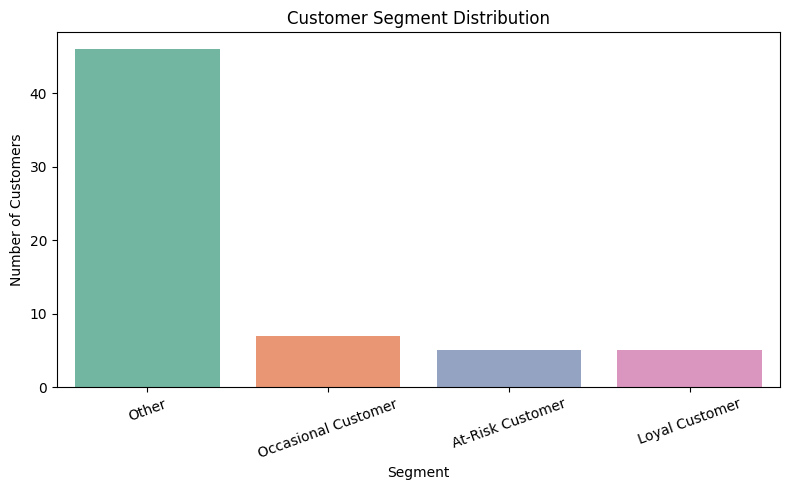

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=segment_counts, x='Segment', y='Count', palette='Set2')
plt.title("Customer Segment Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


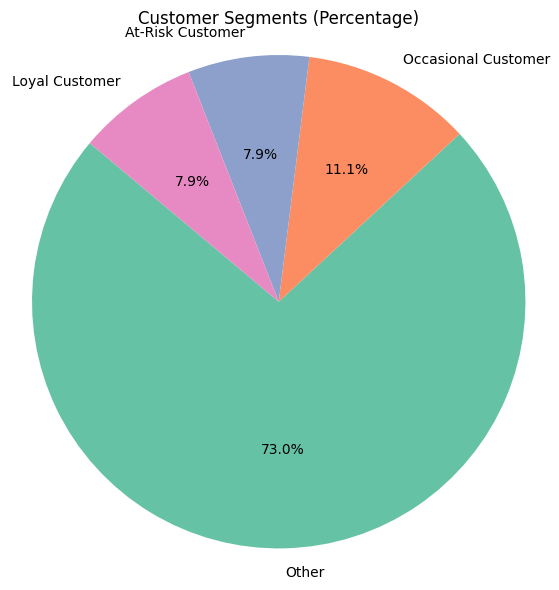

In [38]:
# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(segment_counts['Count'], labels=segment_counts['Segment'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title("Customer Segments (Percentage)")
plt.axis('equal')
plt.tight_layout()
plt.show()


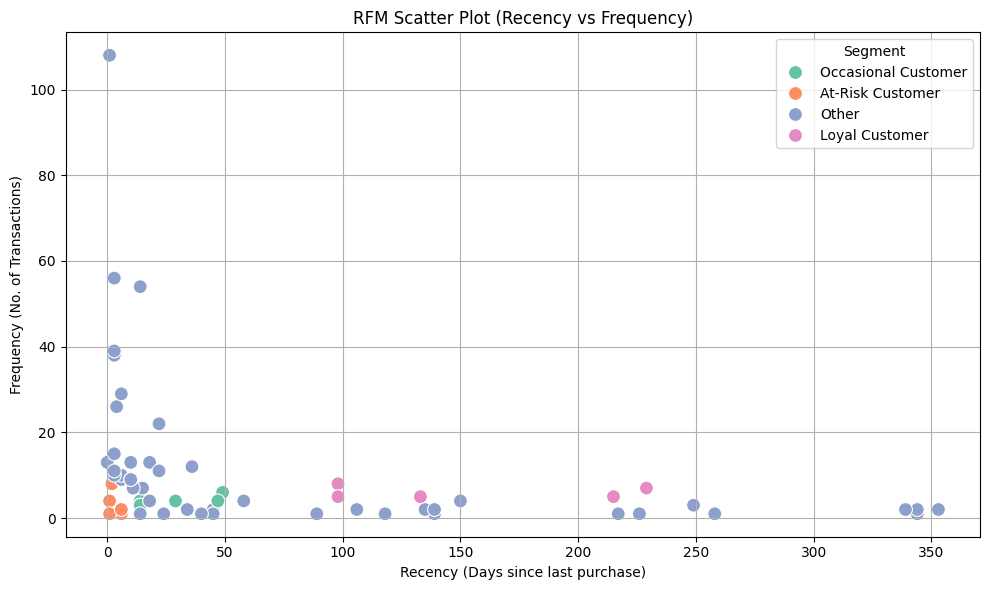

In [39]:
# Scatter plot: Recency vs Frequency with Segment color
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='Set2', s=100)
plt.title("RFM Scatter Plot (Recency vs Frequency)")
plt.xlabel("Recency (Days since last purchase)")
plt.ylabel("Frequency (No. of Transactions)")
plt.legend(title='Segment')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [40]:
# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

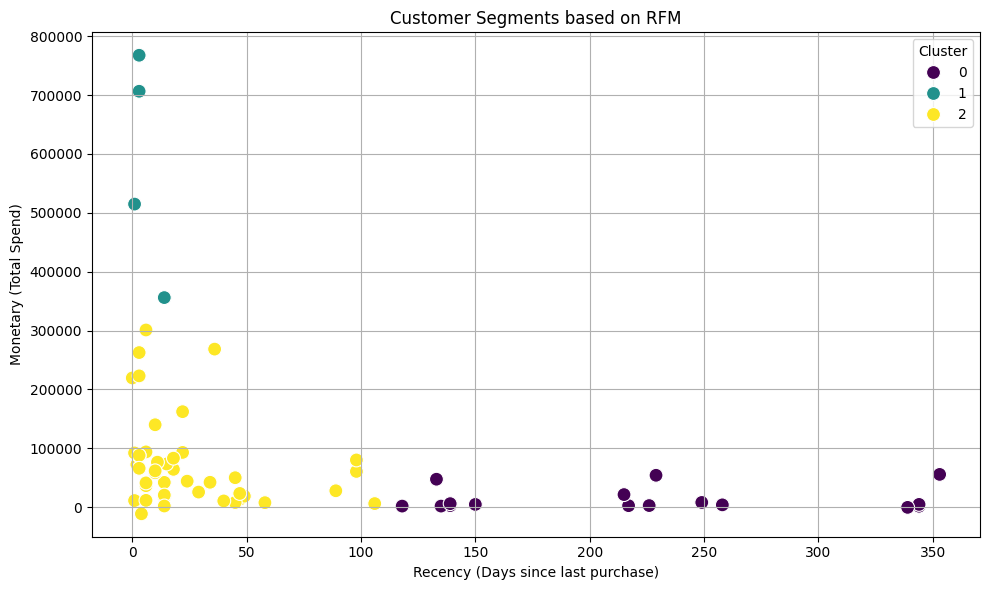

In [41]:
# Plot RFM clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segments based on RFM')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
pip install prophet


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   --- ------------------------------------ 1.0/13.3 MB 2.4 MB/s eta 0:00:06
   --- ------------------------------------ 1.3/13.3 MB 2.2 MB/s eta 0:00:06
   ----- ---------------------------------- 1.8/13.3 MB 2.3 MB/s eta 0:00:05
   -------- ------------------------------- 2.9/13.3 MB 2.8 MB/s eta 0:00:04
   ----------- ---------------------------- 3.7/13.3 MB 3.1 MB/s eta 0:00:04
   -------------- ------------------------- 4.7/13.3 MB 3.4 MB/s eta 0:00:03
   ------------------ --------------------- 6.0/13.3 MB 3.9 MB/s eta 0:00:02
   --------------------- ------------------ 7.1/13.3 MB 4.1 MB/s eta 0:00:02
   ------------------------ --------------- 8.1/13.3 MB 4.1 MB/s eta 0:00:02
   ----------------

In [43]:
import pandas as pd

# Load your sheet
df = pd.read_excel("updated_data (1) - Copy.xlsx", sheet_name="Monthly Sales Trends")

# Rename columns
df.columns = ['Month', 'Sales']

# Remove rows with non-numeric months like "Row Labels"
df = df[df['Month'].astype(str).str.isnumeric()]

# Now safely convert Month to integer
df['Month'] = df['Month'].astype(int)

# Convert to datetime (adjust year if needed)
df['ds'] = pd.to_datetime('2021-' + df['Month'].astype(str) + '-01')

# Rename sales column for Prophet
df['y'] = pd.to_numeric(df['Sales'], errors='coerce')

# Drop NaNs
df = df.dropna(subset=['ds', 'y'])


11:47:50 - cmdstanpy - INFO - Chain [1] start processing
11:47:50 - cmdstanpy - INFO - Chain [1] done processing


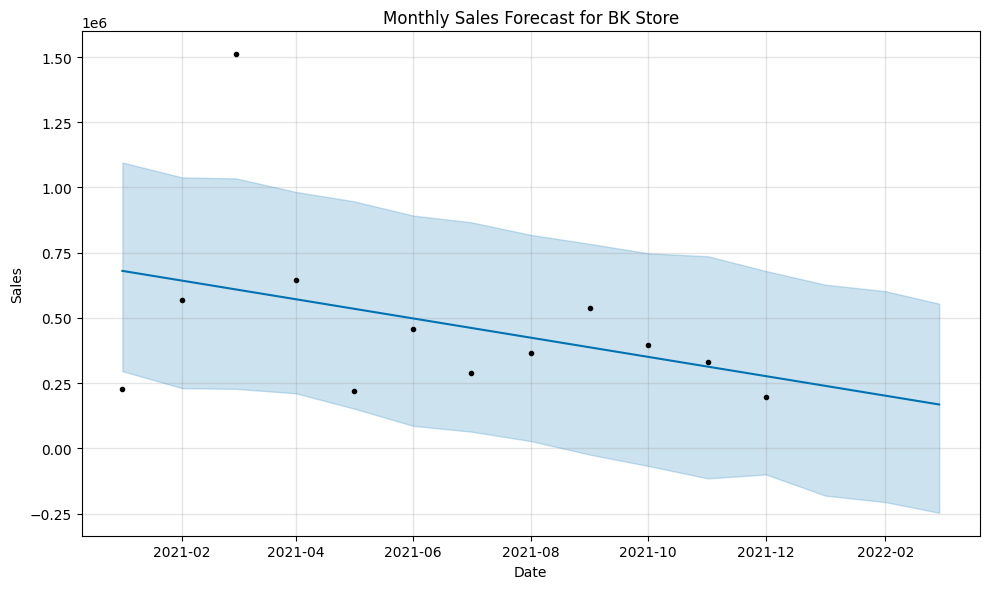

In [44]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize and fit the model
model = Prophet()
model.fit(df[['ds', 'y']])

# Forecast next 3 months
future = model.make_future_dataframe(periods=3, freq='MS')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Monthly Sales Forecast for BK Store")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


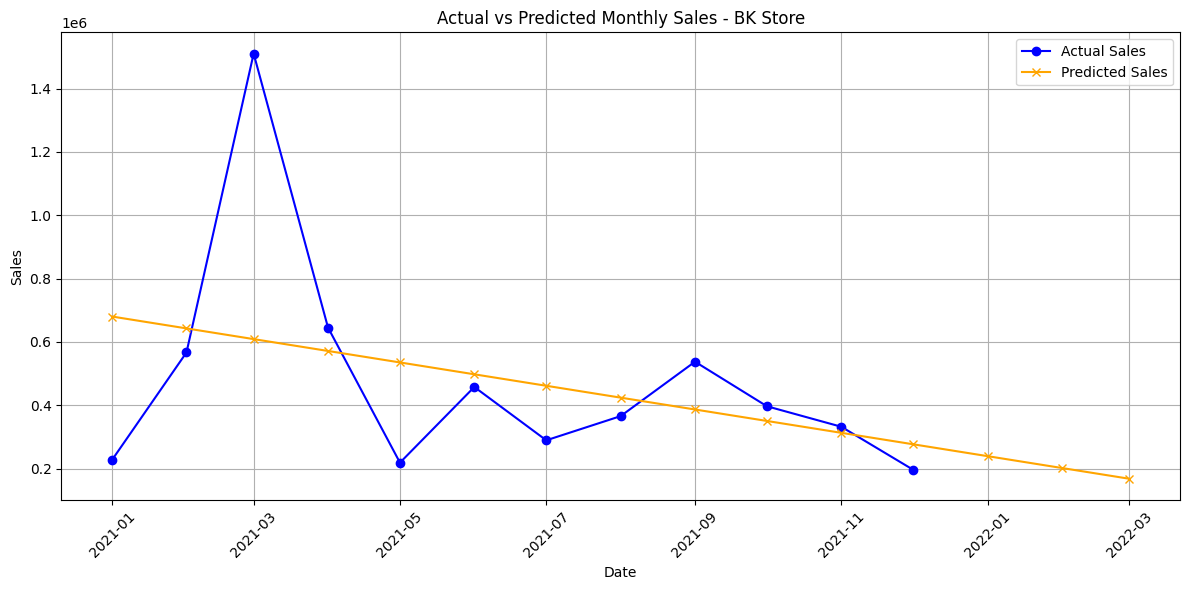

In [45]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(df['ds'], df['y'], label='Actual Sales', marker='o', color='blue')

# Plot predicted sales from forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Sales', marker='x', color='orange')

# Customize plot
plt.title('Actual vs Predicted Monthly Sales - BK Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
